In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.patches import Circle
import os
import pickle
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, f_oneway
from statannotations.Annotator import Annotator
from itertools import combinations

In [2]:

df_food = pd.read_csv("df_food_filtered_with_food_group.csv",index_col=0)
with open("df_food_openfoodfacts_merged.pkl", "rb") as f:
    df_food_openfoodfacts = pickle.load(f, encoding="latin1")

C:\Users\Sophie\AppData\Local\Temp\ipykernel_2960\1967521514.py:1: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food = pd.read_csv("df_food_filtered_with_food_group.csv",index_col=0)


In [3]:
df_food = df_food[df_food["eaten_quantity_in_gram"] > 0]
df_food = df_food[df_food["energy_kcal_eaten"] > 0]

In [6]:
df_food_scaled = pd.read_csv('df_food_scaled.csv')

C:\Users\Sophie\AppData\Local\Temp\ipykernel_2960\4074791732.py:1: DtypeWarning: Columns (1,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_scaled = pd.read_csv('df_food_scaled.csv')


In [9]:
nutrient_info = {
    'folate_eaten':                                         {'unit': 'mcg', 'target': 400,  'type': 'qualifying'},
    'niacin_eaten':                                         {'unit': 'mg',  'target': 14,   'type': 'qualifying'},
    'pantothenic_acid_eaten':                               {'unit': 'mg',  'target': 5,    'type': 'qualifying'},
    'vitamin_b2_eaten':                                     {'unit': 'mg',  'target': 1.1,  'type': 'qualifying'},
    'vitamin_b1_eaten':                                     {'unit': 'mg',  'target': 1.2,  'type': 'qualifying'},
    'all_trans_retinol_equivalents_activity_eaten':         {'unit': 'IU',  'target': 700,  'type': 'qualifying'},
    'beta_carotene_eaten':                                  {'unit' : 'mcg','target' : 700, 'type' :'qualifying'},
    'vitamin_b12_eaten':                                    {'unit': 'mcg', 'target': 2.4,  'type': 'qualifying'},
    'vitamin_b6_eaten':                                     {'unit': 'mg',  'target': 1.3,  'type': 'qualifying'},
    'vitamin_c_eaten':                                      {'unit': 'mg',  'target': 75,   'type': 'qualifying'},
    'vitamin_d_eaten':                                      {'unit': 'mcg', 'target': 7.5,  'type': 'qualifying'},
    'vitamin_e_activity_eaten':                             {'unit': 'TAE', 'target': 15,    'type': 'qualifying'},
    'calcium_eaten':                                        {'unit': 'mg',  'target': 1000, 'type': 'qualifying'},
    'iron_eaten':                                           {'unit': 'mg',  'target': 18,   'type': 'qualifying'},
    'magnesium_eaten':                                      {'unit': 'mg',  'target': 320,  'type': 'qualifying'},
    'phosphorus_eaten':                                     {'unit': 'mg',  'target': 700,  'type': 'qualifying'},
    'potassium_eaten':                                      {'unit': 'mg',  'target': 4700, 'type': 'qualifying'},
    'zinc_eaten':                                           {'unit': 'mg',  'target': 8,    'type': 'qualifying'},
    'fiber_eaten':                                          {'unit': 'g',   'target': 25,   'type': 'qualifying'},
    'protein_eaten':                                        {'unit': 'g',   'target': 46,   'type': 'qualifying'},
    'fat_eaten':                                            {'unit': 'g',   'target': 78,   'type': 'disqualifying'},
    'fatty_acids_saturated_eaten':                          {'unit': 'g',   'target': 22,   'type': 'disqualifying'},
    'cholesterol_eaten':                                    {'unit': 'mg',  'target': 300,  'type': 'disqualifying'},
    'sugar_eaten':                                          {'unit': 'g',   'target': 125,  'type': 'disqualifying'},
    'sodium_eaten':                                         {'unit': 'mg',  'target': 2400, 'type': 'disqualifying'},
    'salt_eaten' :                                          {'unit' : 'g',  'target': 6,   'type': 'disqualifying'}
}


conversion_factors = {
    "mg": 1000,
    "g": 1,
    "mcg": 1000000,
    "IU": 1,
    "TAE": 1,
}

In [10]:
qualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'qualifying'}
disqualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'disqualifying'}

In [5]:
df_food_scaled[['QI', 'DI','NB', 'combined_name', 'food_group']].groupby('food_group').median(numeric_only=True).sort_values('QI')

,QI,DI,NB
food_group,,,
alcoholic_beverages,0.038127,0.007668,3.812709
sweetened_beverages,0.041806,0.664300,4.180602
others,0.105016,0.666667,5.474351
soups_sauces_condiments,0.117561,1.068889,6.402525
salty_snacks,0.121828,0.535766,10.000000
cooked_grains_pasta,0.135563,0.517566,9.358974
sweets_desserts,0.157373,0.852030,12.639102
vegetable_oils,0.245871,0.694173,6.645221
butter_margarine_spreads,0.284294,1.837749,15.794434


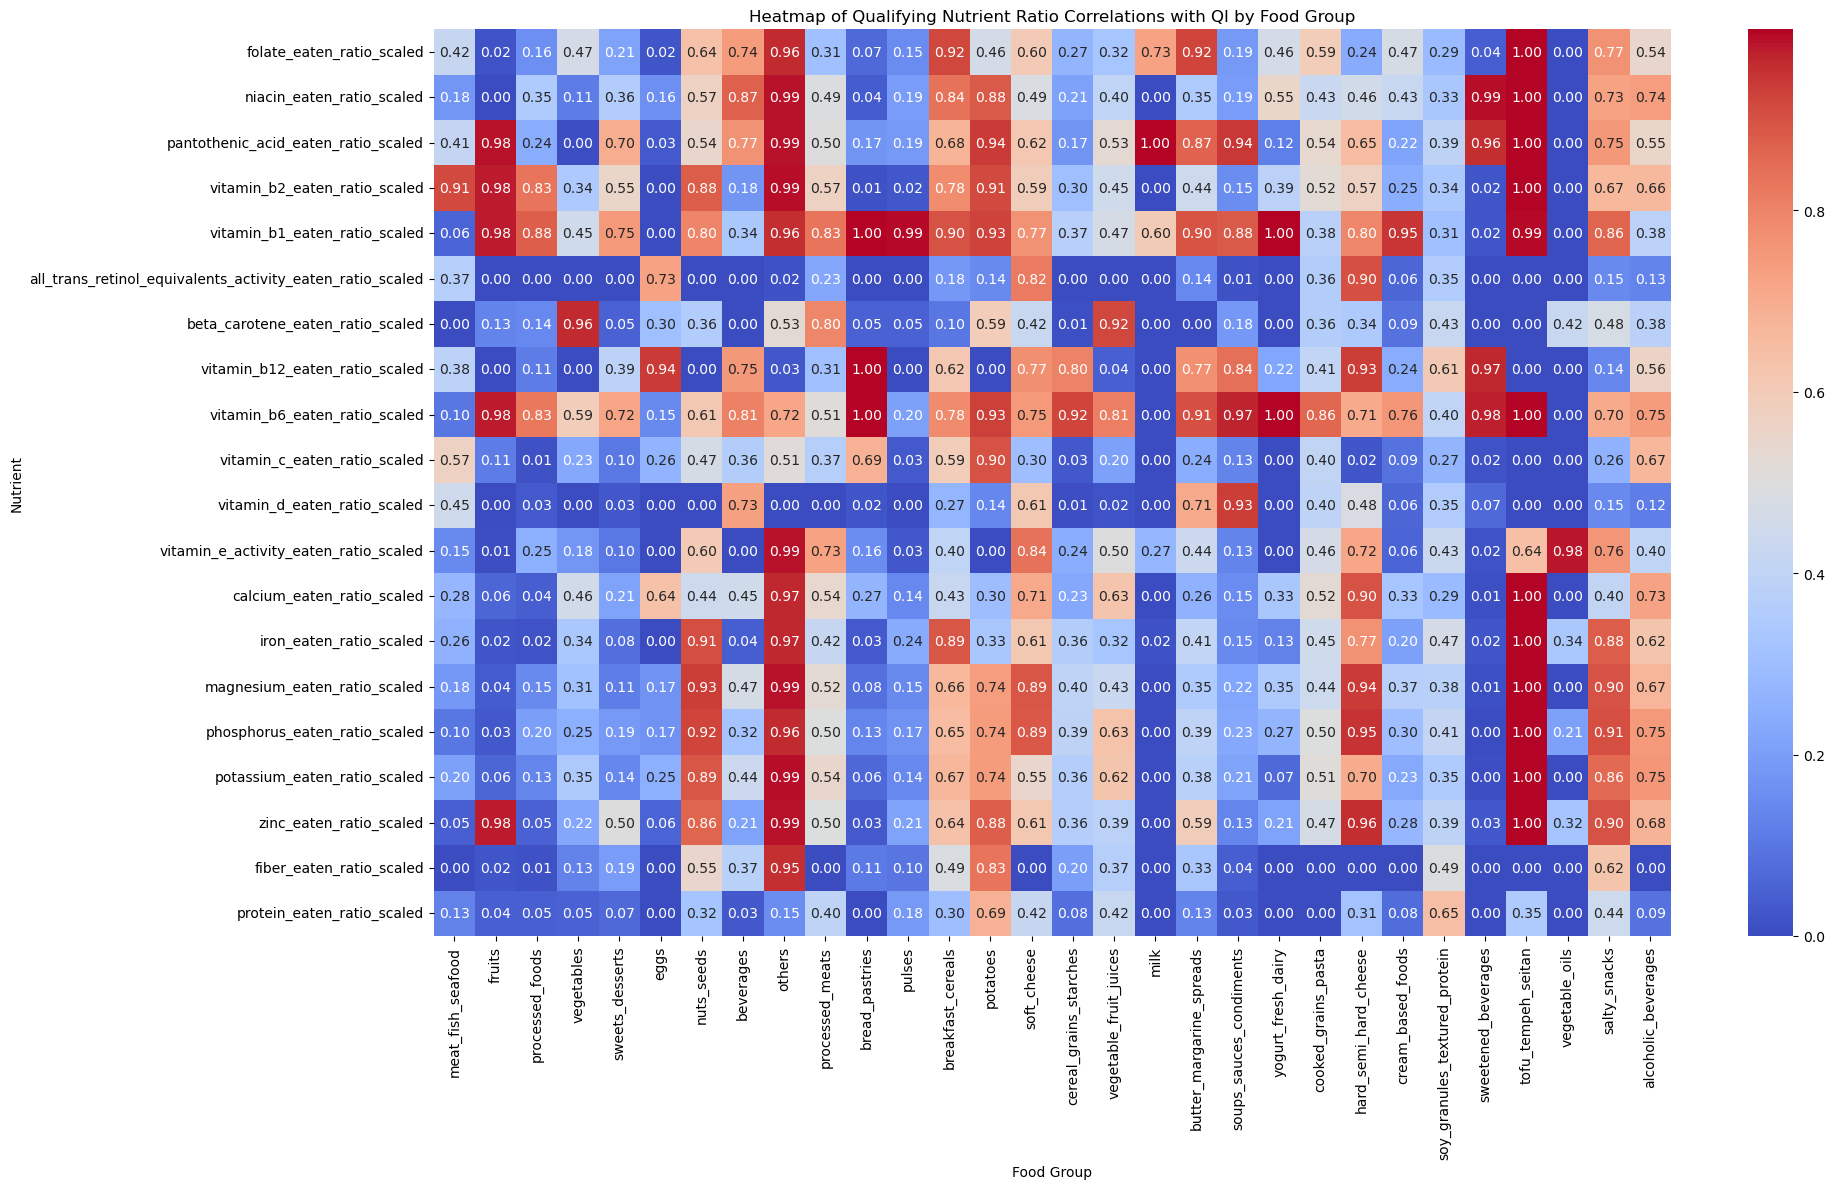

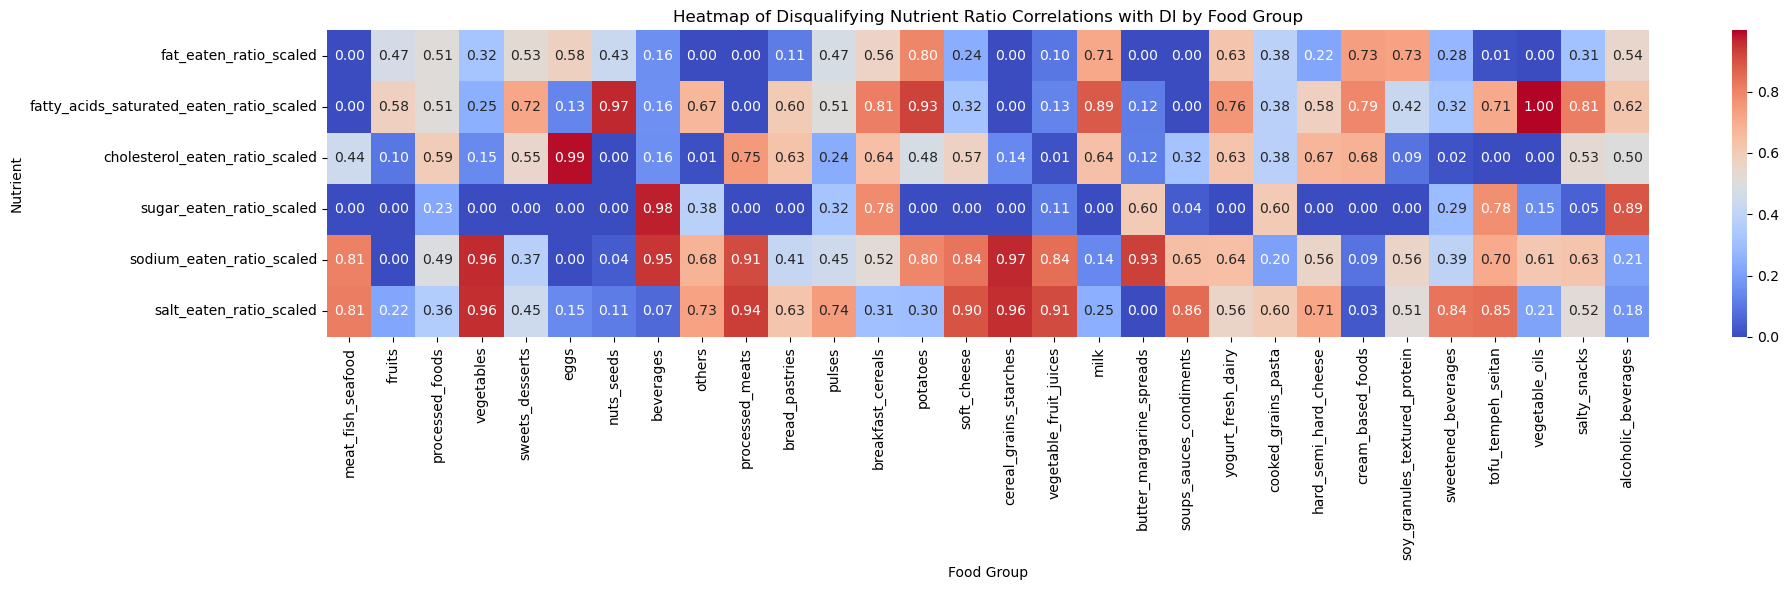

In [19]:

qi_ratio_cols = [col for col in df_food_scaled.columns if col.endswith('_ratio_scaled') and col.replace('_ratio_scaled','') in qualifying_nutrients]

di_ratio_cols = [col for col in df_food_scaled.columns if col.endswith('_ratio_scaled') and col.replace('_ratio_scaled','') in disqualifying_nutrients]

food_groups = df_food_scaled['food_group'].unique()

qi_corr_dict = {}
for group in food_groups:
    df_group = df_food_scaled[df_food_scaled['food_group'] == group]

    df_corr = df_group[qi_ratio_cols + ['QI']]

    corr_series = df_corr.corr()['QI'].loc[qi_ratio_cols]
    corr_series = corr_series.fillna(0).apply(lambda x: x if x > 0 else 0)
    qi_corr_dict[group] = corr_series

df_qi_corr = pd.DataFrame(qi_corr_dict)

#print("QI Correlation Table:")
#print(df_qi_corr)

plt.figure(figsize=(20,12))
sns.heatmap(df_qi_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Heatmap of Qualifying Nutrient Ratio Correlations with QI by Food Group")
plt.xlabel("Food Group")
plt.ylabel("Nutrient")
plt.tight_layout()
plt.show()


di_corr_dict = {}
for group in food_groups:
    df_group = df_food_scaled[df_food_scaled['food_group'] == group]
    df_corr = df_group[di_ratio_cols + ['DI']]
    corr_series = df_corr.corr()['DI'].loc[di_ratio_cols]
    corr_series = corr_series.fillna(0).apply(lambda x: x if x > 0 else 0)
    di_corr_dict[group] = corr_series

df_di_corr = pd.DataFrame(di_corr_dict)
#print("DI Correlation Table:")
#print(df_di_corr)

plt.figure(figsize=(20,6))
sns.heatmap(df_di_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Heatmap of Disqualifying Nutrient Ratio Correlations with DI by Food Group")
plt.xlabel("Food Group")
plt.ylabel("Nutrient")
plt.tight_layout()
plt.show()


In [ ]:
ranking_avg = df_qi_corr.mean(axis=1).sort_values(ascending=False)
print("\nRanking by average correlation across food groups (QI) :")
print(ranking_avg)



Ranking by average correlation across food groups (QI) :
vitamin_b6_eaten_ratio_scaled                                0.680872
vitamin_b1_eaten_ratio_scaled                                0.651504
pantothenic_acid_eaten_ratio_scaled                          0.548253
vitamin_b2_eaten_ratio_scaled                                0.476995
zinc_eaten_ratio_scaled                                      0.449451
niacin_eaten_ratio_scaled                                    0.443456
phosphorus_eaten_ratio_scaled                                0.438166
folate_eaten_ratio_scaled                                    0.432688
magnesium_eaten_ratio_scaled                                 0.428529
potassium_eaten_ratio_scaled                                 0.407103
vitamin_b12_eaten_ratio_scaled                               0.393988
calcium_eaten_ratio_scaled                                   0.389410
iron_eaten_ratio_scaled                                      0.375827
vitamin_e_activity_eaten_ratio_s

In [26]:

"""
top_nutrient_per_group = df_qi_corr.idxmax()
ranking_top_freq = top_nutrient_per_group.value_counts().sort_values(ascending=False)
print("\nRanking by frequency as top nutrient:")
print(ranking_top_freq)"
"""

'\ntop_nutrient_per_group = df_qi_corr.idxmax()\nranking_top_freq = top_nutrient_per_group.value_counts().sort_values(ascending=False)\nprint("\nRanking by frequency as top nutrient:")\nprint(ranking_top_freq)"\n'

In [25]:
ranking_avg = df_di_corr.mean(axis=1).sort_values(ascending=False)
print("\nRanking by average correlation across food groups (DI) :")
print(ranking_avg)



Ranking by average correlation across food groups (DI) :
sodium_eaten_ratio_scaled                   0.545103
salt_eaten_ratio_scaled                     0.521220
fatty_acids_saturated_eaten_ratio_scaled    0.489597
cholesterol_eaten_ratio_scaled              0.367920
fat_eaten_ratio_scaled                      0.327632
sugar_eaten_ratio_scaled                    0.206880
dtype: float64
